# Market Making with Reinforcement Learning

In [94]:
# Data Handling
import pandas as pd
import numpy as np
import pickle

# Generic
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Libraries import environment as env
from Libraries import agents as ag
from Libraries import tiling
from Libraries.data_handling import DataGenerator
from Libraries.utils import RLProblem
from Libraries.policies import EpsilonGreedyPolicy

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Define the state space boundaries

In [95]:
levels = 1
horizon = 50
stockname = 'toy'
data_generator = DataGenerator(f'data/{stockname}.parquet', levels=levels, horizon=horizon, sequential=False)
lob_data = data_generator[0]

print(f'There is a total of {len(data_generator)} episodes in the dataset')
print(f'The {round(len(data_generator)/horizon)} are unique episodes')

There is a total of 2458 episodes in the dataset
The 49 are unique episodes


In [96]:
action_bounds = np.array([-1, 9])
# Compute state space bounds
agent_state_bounds = np.array([
    [-1e5, 1e5], # Inventory
    [0,2], # Spread
    [-1,5], # Theta_a
    [-1,5], # Theta_b
])
market_state_bounds = np.array([
    lob_data.min(axis=0) * 0.9,
    lob_data.max(axis=0) * 1.1,
]).T
full_state_bounds = np.vstack([agent_state_bounds, market_state_bounds])

# Add action bounds to each state
agent_state_bounds = np.vstack([agent_state_bounds, action_bounds])
market_state_bounds = np.vstack([market_state_bounds, action_bounds])
full_state_bounds = np.vstack([full_state_bounds, action_bounds])

# Group in a list
state_space_boundaries = [agent_state_bounds, market_state_bounds, full_state_bounds]

# Define the Linear Combination of Tile Codings weights
# lctc_weights = np.array([0.3, 0.4, 0.3])
lctc_weights = np.ones(3) / 3

### Define the parameters for the Reinforcement Learning problem

In [97]:
rl_problem_params = {
    'data_path'         : f'data/{stockname}.parquet',
    'levels'            : levels,
    'horizon'           : horizon,
    'environment_class' : env.Case3MarketMakerEnv,
    'phi_transform'     : env.PhiTransform.PnL_asymm_dampened(c=-0.5),
    'state_space_boundaries' : state_space_boundaries,
    # 'agent_class'       : ag.SarsaLambdaAgent,
    'agent_class'       : ag.QLambdaAgent,
    'value_function_class' : tiling.SparseTileEncodingApproximator,
    'lctc_weights'    : lctc_weights,
    'value_approx_params' : {
        'n_tiles' : 8,
        'n_tilings' : 32,
        'offset' : 0.17,
        # 'n_weights' : 4096,
        'n_weights' : 16384,

    },
    'agent_params' : {
        'alpha' : 1e-3,
        'gamma' : 0.99,
        'el_decay' : 0.96,
    },
    'policy_class' : EpsilonGreedyPolicy,
    'policy_params' : {
        'epsilon' : 0.2,
        'epsilon_decay' : 0.9975,
        'epsilon_min' : 1e-1,
    },
}

rl_problem = RLProblem._from_dict(rl_problem_params)

### Train

In [98]:
train_rewards, train_infos = rl_problem.train(
    n_scenarios=50,
    episodes_per_scenario=1,
    iterarations_per_episode=1,
    verbose=True
)

# Save with pickle
# with open('train_rewards.pkl', 'wb') as f:
#     pickle.dump(train_rewards, f)

# with open('train_infos.pkl', 'wb') as f:
#     pickle.dump(train_infos, f)

  0%|          | 0/50 [00:00<?, ?it/s]

In [99]:
# # First scenario
# display(train_rewards[0].shape)
# # First scenario, first episode
# display(train_rewards[0][0].shape)
# # First scenario, first episode, first iteration
# display(train_rewards[0][0][0])

In [100]:
# train_rewards[i] has shape (n_episodes, n_iterations)
# Average reward over all scenarios
# rew = np.array(list(train_rewards.values()))
# avg_rew = rew.mean(0)

In [101]:
# from scipy.interpolate import make_interp_spline

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# # Color map from light blue to blue
# color_gammas = plt.cm.Blues(np.linspace(0.2, 1, avg_rew.shape[0]))
# for i in range(avg_rew.shape[0]):
#     spline = make_interp_spline(
#         np.arange(avg_rew[i].shape[0]),
#         avg_rew[i],
#         k=3,
#         bc_type='clamped'
#     )
#     x = np.linspace(0, avg_rew[i].shape[0], 1000)
#     y = spline(x)
#     # ax.plot(avg_rew[i], label=f'Scenario {i+1}', color=color_gammas[i])
#     ax.plot(x, y, label=f'Episode {i+1}', color=color_gammas[i])
# ax.legend()
# ax.set_title('Average Reward per Episode')
# fig.tight_layout()
# plt.show()

### Test

In [102]:
test_rewards, test_infos = rl_problem.test(
    n_scenarios=10,
    epsilon=0.0,
    oos=True,
    verbose=True
)

# Save with pickle
# with open('test_rewards.pkl', 'wb') as f:
#     pickle.dump(test_rewards, f)

# with open('test_infos.pkl', 'wb') as f:
#     pickle.dump(test_infos, f)

  0%|          | 0/10 [00:00<?, ?it/s]

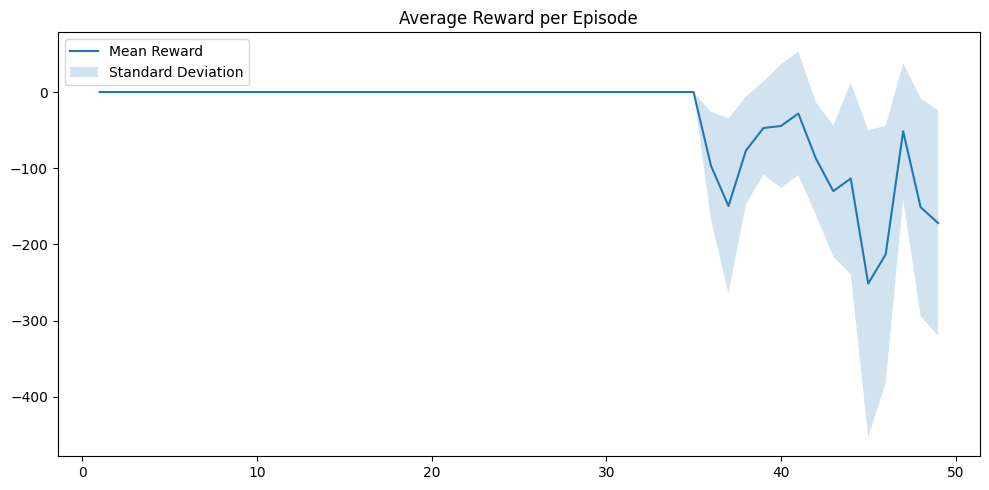

In [103]:
df_rewards = pd.DataFrame(test_rewards)
# df_rewards.to_parquet('test_rewards.parquet', index=False, compression='lz4')
# Compute the mean and std reward per episode
rewards_mean = df_rewards.mean(axis=1)
rewards_std = 1*df_rewards.std(axis=1)

# Compute SMA
rewards_mean = rewards_mean.rolling(window=2).mean()
rewards_std = rewards_std.rolling(window=2).mean()

fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.plot(rewards_mean[:40], label='Mean Reward')
# ax.fill_between(rewards_mean.index[:40], (rewards_mean - rewards_std)[:40], (rewards_mean + rewards_std)[:40], alpha=0.2, label='Standard Deviation')
ax.plot(rewards_mean, label='Mean Reward')
ax.fill_between(rewards_mean.index, (rewards_mean - rewards_std), (rewards_mean + rewards_std), alpha=0.2, label='Standard Deviation')
ax.legend()
ax.set_title('Average Reward per Episode')
fig.tight_layout()
plt.show()